# 5 - Feature Selection

## Introduction:

One of the most common problem in a dataset is __Noise__. Noise are features within the dataset that may not be highly predictive of the response variable, and in some cases will hinder the ML model's performance. There are techniques that can be employed to deal with the Noise to a certain degree, as done in previous projects, this woud include standardisation and normalisation. However, these two techniques does not directly deal with the Noise in the data. 

This is where __Feature Selection__ comes into play, where it is the process of selecting features from the original batch of features from the dataset, that produces the best model prediction outcome in a pipeline. Formally, this can be described as, given "n" number of features, search a subset "k" features, where "k < n", that improves thhe ML modeling pipeline.

This project will venture into 2 sections:
1. Statistical-based feature selection
2. Model-based feature selection.

## Breakdown of this Project:
- How to gain better performance with feature engineering.
- Creating a baseline ML modeling pipeline.
- Types of Feature Selection.
- Choosing the right feature selection method. 

## Datasets:

Link: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

Dataset Description: This dataset consists of customer's default payments in Taiwan.

Attribute Information:

The target variable is binary, default payment (Yes = 1, No = 0).

There are 23 feature (attribute) variables:
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
- X2: Gender (1 = male; 2 = female).
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- X4: Marital status (1 = married; 2 = single; 3 = others).
- X5: Age (year).
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
- X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

## Requirements:
- sklearn (scikit-learn)
- numpy
- pandas
- os
- timeit
- seaborn
 



In [1]:
import pandas as pd
import numpy as np
import timeit
import os
import seaborn as sns

## 1 - How to gain better performance with feature engineering?

In previous projects, tthe accuracy or RSME metrics of the model predictions were used to measure its performance. There are of course othehr metircs that can be utilised and to name a few, these are:

For classification tasks:
1. True and False Positive rates.
2. Sensitivity (TP rate) and specificity.
3. False negatives and False positve rate.

For Regression tasks:
1. Mean Absolute Error.
2. R-squared.

An alternative to model performance metrics are the Meta-Metrics, such as:
- Time taken to train the model to the dataset.
- Time taken for a fitted model to predict on new instances of the data.
- The size of the data that is persisted.

### 1.1 - Metric Tracking:

To help track these metrics bettwe, define a function to evaluate on several model's performance, and it should be specific enough to provide metrics for each individual model.

In [2]:
# Import the required libraries:
from sklearn.model_selection import GridSearchCV

In [3]:
def get_best_model_and_accuracy(model, params, X, y):
    """ This function will run the model with its set parameters, with the dataset.
        It does so by using sklearn's GridSearchCV.
    Parameters:
        - model, is the input model to be used.
        - params, is the Dict of parameters for the model
        - X, is the training dataset.
        - y, is the target variable.
    Returns:
        - returns the Best Accuracy, Best Parameters used, Average time to fit and Average time to Score.
    """
    # Define the GridSearchCV:
    grid = GridSearchCV(estimator=model, param_grid=params, error_score=0., n_jobs=-1)
    
    # Fit the model to the dataset:
    grid.fit(X, y)
    
    # Classical metric for performance:
    print("Best Accuracy: {:.3f}%".format( (100 * grid.best_score_) ))
    
    # Best parameters that caused the best accuracy
    print("Best Parameters: {}".format(grid.best_params_))
    
    # Average time it took a model to fit to the data (in seconds)
    print("Average Time to Fit (s): {}".format(round(grid.cv_results_['mean_fit_time'].mean(), 
                                                     ndigits=3)))
    
    # Average time it took a model to predict out of sample data (in seconds)
    # this metric gives us insight into how this model will perform in real-time analysis
    print("Average Time to Score (s): {}".format(round(grid.cv_results_['mean_score_time'].mean(), 
                                                       ndigits=3)))

### 1.2 - Credit Card Defaulting Dataset:

Throughout this project, the important features will be extracted and the noise will be ignored, therefore the goals are:
1. __Improving the model performance__ - Removing irrelevant data and redundant data to reduce the noise, providing (as best as possible) the best features for the model to learn from.
2. __Reducing training time and prediction time__ - By fitting pipelines to less data at each stage, it will result in a better model fit and prediction times. This means the pipelines will be faster overall.

## 2 - Load in the Dataset:

In [4]:
# Define the Working Directory for the Dataset:
currentDirectory = os.getcwd()
path_to_dataset = currentDirectory + "/Dataset/"

# Load in the dataset:
credit_card_default_dataset_df = pd.read_csv(path_to_dataset + 'credit_card_default.csv')

### 2.1 - First glance at the dataset:

In [5]:
# Inspect:
credit_card_default_dataset_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
# Inspect the shape:
credit_card_default_dataset_df.shape

(30000, 24)

### 2.2 - Dataset Statistics:

In [7]:
credit_card_default_dataset_df.describe().T

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0


It can be seen that the scales for each column are different from each other, this meant that Standardisation and Normalisation will be required. However, in this project, this will be ignored for now.

### 2.4 - Check for Missing Values:

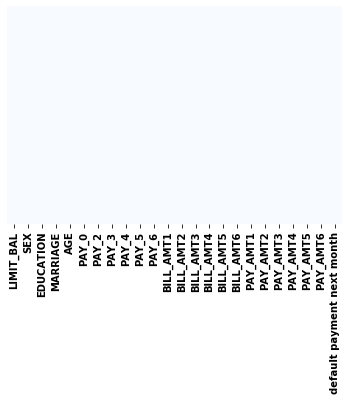

In [8]:
sns.heatmap(data=credit_card_default_dataset_df.isnull(), yticklabels=False, cbar=False, cmap = "Blues")

Looks like there aren't any missing values so far.

### 2.5 - Set up the Dataset with Features and Target Variable(s):

Here, the Response (Target) Variable is "default payment next month". The rest will be used as the features.

In [9]:
# For the Features:
X_features_credit = credit_card_default_dataset_df.drop('default payment next month', axis=1)

# For the Target variable:
y_target_credit = credit_card_default_dataset_df['default payment next month']

## 3 - Creating the baseline ML Pipeline:

Let's firstly determine the NULL Accuracy:

In [10]:
y_target_credit.value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default payment next month, dtype: float64

The NULL Accuracy here is 77.88%. This would be the accuracy to beat.

## 3.1 - Baseline ML Pipeline setup:

Here, there will be 4 types of ML models being employed and these are:
1. Logistic Regression.
2. K-Nearest Neighbours.
3. Decision Trees.
4. Random Forest.

In [11]:
# Import the required libraries:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Next, is to run each one of these models and obtain a baseline metrics: accuracy and so on.

In [12]:
# Define the parameters for each of the models:
lr_params = {'C':[1e-1, 1e0, 1e1, 1e2], 'penalty':['l1', 'l2']}

knn_params = {'n_neighbors': [1, 3, 5, 7]}

tree_params = {'max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}

forest_params = {'n_estimators': [10, 50, 100], 'max_depth': [None, 1, 3, 5, 7]}

In [13]:
# Instantiate the models:
logReg = LogisticRegression(max_iter=10000)
knn = KNeighborsClassifier()
decision_tree = DecisionTreeClassifier()
randomForest = RandomForestClassifier()

#### For Logistic Regression:

In [14]:
get_best_model_and_accuracy(model=logReg, 
                            params=lr_params, 
                            X=X_features_credit, 
                            y=y_target_credit)

Best Accuracy: 77.877%
Best Parameters: {'C': 0.1, 'penalty': 'l2'}
Average Time to Fit (s): 0.528
Average Time to Score (s): 0.001


#### For KNN:

Note that for KNN model, it uses the Euclidean distance to make predictions and this means that it is highly sensitive to non-standardised data. The model's performance will be hindered. But first, let's get the non-scaled accuracy.

In [15]:
get_best_model_and_accuracy(model=knn, 
                            params=knn_params, 
                            X=X_features_credit, 
                            y=y_target_credit)

Best Accuracy: 76.173%
Best Parameters: {'n_neighbors': 7}
Average Time to Fit (s): 0.24
Average Time to Score (s): 0.965


#### Scale the dataset for KNN.

In [16]:
# Define the pipeline parameters:
knn_pipe_params = {'classifier__{}'.format(k): v for k, v in knn_params.items()}
print(knn_pipe_params)

# Define tthe pipeline with the scaler:
knn_pipe = Pipeline([('scale', StandardScaler()), ('classifier', knn)])

# Fit the model:
get_best_model_and_accuracy(model=knn_pipe, 
                            params=knn_pipe_params, 
                            X=X_features_credit, 
                            y=y_target_credit)

{'classifier__n_neighbors': [1, 3, 5, 7]}
Best Accuracy: 79.933%
Best Parameters: {'classifier__n_neighbors': 7}
Average Time to Fit (s): 0.277
Average Time to Score (s): 10.171


#### For Decision Tree:

In [17]:
get_best_model_and_accuracy(model=decision_tree, 
                            params=tree_params, 
                            X=X_features_credit, 
                            y=y_target_credit)

Best Accuracy: 82.063%
Best Parameters: {'max_depth': 3}
Average Time to Fit (s): 0.337
Average Time to Score (s): 0.002


#### For Random Forest:

In [18]:
get_best_model_and_accuracy(model=randomForest, 
                            params=forest_params, 
                            X=X_features_credit, 
                            y=y_target_credit)

Best Accuracy: 81.970%
Best Parameters: {'max_depth': 7, 'n_estimators': 100}
Average Time to Fit (s): 1.629
Average Time to Score (s): 0.034


All the baseline metrics for each of the model have been estalished. The NULL Accuracy to beat is 77.88%.

Comparing all the models, the non-scaled KNN and Logistic Regression model did not perform any better than the null accuracy. The 3 models that did better are the scaled-KNN, Decision Tree and Random Forest models. The best among these is the Decision Tree model. In terms of time taken to score, the Logistic Regression model was the fastest and the Decision Tree coming in second.

#### Summary of the model's baseline performances:

| Model Name | Accuracy (%) | Fit Time (s) | Predict Time (s) |
| --- | --- | --- | --- |
| Logistic Regression | 77.877% | 0.567 | 0.001 |
| scaled KNN | 79.933% | 0.289 | 10.496 |
| Decision Tree | 82.063% | 0.335 | 0.002 |
| Random Forest | 81.940% | 1.563 | 0.033 |

From the results, the Decision Tree will be used for the remainder of the project. This means that the __baseline accuracy is 82.06%__. 

## 4 - Types of Feature Selection:

__Statistical-Based Feature Selection__: This methhod relies on statistical tests to select features during the training phase and does not rely on ML models.

__Model-Based Feature Selection__: This method relies on a pre-processing step involving training a secondary ML model and using this ML model's predictive power to select the features.

Both of these techniques attempts to reduce the size of the data and selects the features with the most predictive power. 


## 4.1 - Statistical-Based Feature Selection:

Statistical-Based Feature Selection can be used to intterpret both Quantitaitve and Qualitative data. It extends more than just mean and standard deviations (for example, to compute the Z-score and scale the data), and relies on two additional concepts:
1. Pearson Correlations.
2. Hypothesis Testing.

Both of the methods above are known as __Univariate__ methhods of feature selection, meaning it provides a quick and handy way to select out a single feature at a time for a better dataset.

### 4.1.1 - Pearson Correlation to select features:

Pearson Correlations coefficients measures the __linear relationship__ between columns, it ranges between -1 and +1 where 0 means no correlation between the features. Correlations that are closer to -1 or +1 implies a strong linear relationship. 

Note:: This correlation method requires each column to be normally distributed, but it can be ignored here as the dataset is large.



In [19]:
# Import the required library:
import matplotlib.style as style

# set a uniform style
style.use('fivethirtyeight')

In [20]:
# Pearson Correlation on the dataset:
credit_card_default_dataset_df.corr()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
LIMIT_BAL,1.000000,0.024755,-0.219161,-0.108139,0.144713,-0.271214,-0.296382,-0.286123,-0.267460,-0.249411,...,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595,-0.153520
SEX,0.024755,1.000000,0.014232,-0.031389,-0.090874,-0.057643,-0.070771,-0.066096,-0.060173,-0.055064,...,-0.021880,-0.017005,-0.016733,-0.000242,-0.001391,-0.008597,-0.002229,-0.001667,-0.002766,-0.039961
EDUCATION,-0.219161,0.014232,1.000000,-0.143464,0.175061,0.105364,0.121566,0.114025,0.108793,0.097520,...,-0.000451,-0.007567,-0.009099,-0.037456,-0.030038,-0.039943,-0.038218,-0.040358,-0.037200,0.028006
MARRIAGE,-0.108139,-0.031389,-0.143464,1.000000,-0.414170,0.019917,0.024199,0.032688,0.033122,0.035629,...,-0.023344,-0.025393,-0.021207,-0.005979,-0.008093,-0.003541,-0.012659,-0.001205,-0.006641,-0.024339
AGE,0.144713,-0.090874,0.175061,-0.414170,1.000000,-0.039447,-0.050148,-0.053048,-0.049722,-0.053826,...,0.051353,0.049345,0.047613,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478,0.013890
PAY_0,-0.271214,-0.057643,0.105364,0.019917,-0.039447,1.000000,0.672164,0.574245,0.538841,0.509426,...,0.179125,0.180635,0.176980,-0.079269,-0.070101,-0.070561,-0.064005,-0.058190,-0.058673,0.324794
PAY_2,-0.296382,-0.070771,0.121566,0.024199,-0.050148,0.672164,1.000000,0.766552,0.662067,0.622780,...,0.222237,0.221348,0.219403,-0.080701,-0.058990,-0.055901,-0.046858,-0.037093,-0.036500,0.263551
PAY_3,-0.286123,-0.066096,0.114025,0.032688,-0.053048,0.574245,0.766552,1.000000,0.777359,0.686775,...,0.227202,0.225145,0.222327,0.001295,-0.066793,-0.053311,-0.046067,-0.035863,-0.035861,0.235253
PAY_4,-0.267460,-0.060173,0.108793,0.033122,-0.049722,0.538841,0.662067,0.777359,1.000000,0.819835,...,0.245917,0.242902,0.239154,-0.009362,-0.001944,-0.069235,-0.043461,-0.033590,-0.026565,0.216614
PAY_5,-0.249411,-0.055064,0.097520,0.035629,-0.053826,0.509426,0.622780,0.686775,0.819835,1.000000,...,0.271915,0.269783,0.262509,-0.006089,-0.003191,0.009062,-0.058299,-0.033337,-0.023027,0.204149


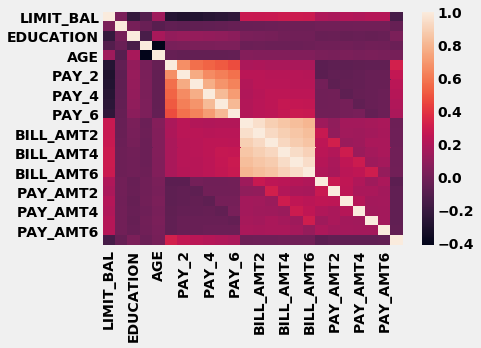

In [21]:
# Plot the heatmap:
sns.heatmap(data=credit_card_default_dataset_df.corr())

__Note__: This method automatically shows the most correlated features. 

Here, is is assumed that the more correlated the feature is to the target variable, the more usefyl this feature is. Correlation coefficients can also be used to find the feature interactions and redundancies. Removing these redundancies also reduces the model overfitting issues.

#### Isolate the correlations between the features and target variable:

In [22]:
credit_card_default_dataset_df.corr()['default payment next month']

LIMIT_BAL                    -0.153520
SEX                          -0.039961
EDUCATION                     0.028006
MARRIAGE                     -0.024339
AGE                           0.013890
PAY_0                         0.324794
PAY_2                         0.263551
PAY_3                         0.235253
PAY_4                         0.216614
PAY_5                         0.204149
PAY_6                         0.186866
BILL_AMT1                    -0.019644
BILL_AMT2                    -0.014193
BILL_AMT3                    -0.014076
BILL_AMT4                    -0.010156
BILL_AMT5                    -0.006760
BILL_AMT6                    -0.005372
PAY_AMT1                     -0.072929
PAY_AMT2                     -0.058579
PAY_AMT3                     -0.056250
PAY_AMT4                     -0.056827
PAY_AMT5                     -0.055124
PAY_AMT6                     -0.053183
default payment next month    1.000000
Name: default payment next month, dtype: float64

First, is to ignore the last row as this the Target Variable itself. The list above shows the features that "might" be useful.

#### Now, filter out the features:

These should consist of features that are at least -/+0.20 correlation.

In [23]:
# Filter:
credit_card_default_dataset_df.corr()['default payment next month'].abs() > .2

LIMIT_BAL                     False
SEX                           False
EDUCATION                     False
MARRIAGE                      False
AGE                           False
PAY_0                          True
PAY_2                          True
PAY_3                          True
PAY_4                          True
PAY_5                          True
PAY_6                         False
BILL_AMT1                     False
BILL_AMT2                     False
BILL_AMT3                     False
BILL_AMT4                     False
BILL_AMT5                     False
BILL_AMT6                     False
PAY_AMT1                      False
PAY_AMT2                      False
PAY_AMT3                      False
PAY_AMT4                      False
PAY_AMT5                      False
PAY_AMT6                      False
default payment next month     True
Name: default payment next month, dtype: bool

In [24]:
# Save it as a condition:
highly_corr_features = credit_card_default_dataset_df.columns[credit_card_default_dataset_df.corr()['default payment next month'].abs() > .2]

# Remove the Target Variable:
highly_corr_features = highly_corr_features.drop('default payment next month')

# Inspect:
highly_corr_features

Index(['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5'], dtype='object')

#### Test these features with the model:

Baseline Decision Tree metrics:

Best Accuracy: 82.063% \
Best Parameters: {'max_depth': 3} \
Average Time to Fit (s): 0.335 \
Average Time to Score (s): 0.002

In [25]:
# Take a subset of the dataset with these features:
X_features_credit_subset = X_features_credit[highly_corr_features]

# Run the model:
get_best_model_and_accuracy(model=decision_tree, 
                            params=tree_params, 
                            X=X_features_credit_subset, 
                            y=y_target_credit)

Best Accuracy: 82.133%
Best Parameters: {'max_depth': 3}
Average Time to Fit (s): 0.014
Average Time to Score (s): 0.002


By taking these highly correlated features, the model only performs slightly better, and the model's fitting time improved significantly.

### Build a Custom Correlation Transformer: for Pipeline Compatibility.

This section will build a custom correlation transformer to be part of the pre-processing phase so that it can be ready and compatible with sklearn's pipeline.

In [26]:
# Import the required Libraries:
from sklearn.base import TransformerMixin, BaseEstimator

In [27]:
class CustomCorrelationSelector(TransformerMixin, BaseEstimator):
    """ This builds custom correlation transformer that selects the most highly correlated features
        from the dataset. It inherits the attributes of TransformerMixin and BaseEstimator.
    Parameters:
        - response, is the target variable dataframe.
        - cols_to_keep, is the list of columns of highly correlated features.
        - threshold, is the assigned threshold of for the correlations (e.g. -/+0.20 correlation)
    Returns:
        - returns the Correlation Selector object.
    Notes: 
        - N/A
    """ 
    def __init__(self, response, cols_to_keep=[], threshold=None):
        # Stores the response series:
        self.response = response
        # Store the threshold:
        self.threshold = threshold
        # Feature Column names to keep:
        self.cols_to_keep = cols_to_keep
        
    def transform(self, X):
        # Selects the columns from the dataset:
        return X[self.cols_to_keep]
    
    def fit(self, X, *_):
        # Create a new DataFrame (includes features and response):
        df = pd.concat([X, self.response], axis=1)
        
        # Select and store the correlations (features) that meet the threshold:
        self.cols_to_keep = df.columns[ df.corr()[df.columns[-1]].abs() > self.threshold ]
        
        # Remove the Target Variable and keep only the feature columns:
        self.cols_to_keep = [feature_cols for feature_cols in self.cols_to_keep if feature_cols in X.columns]
        
        return self

#### Test it out:

In [28]:
# Instantiate the Transformer:
ccc = CustomCorrelationSelector(response=y_target_credit, threshold=0.2)

# Fit it to the dataset:
ccc.fit(X_features_credit)

# Inspect:
ccc.cols_to_keep

['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5']

In [29]:
# Inspect:
ccc.transform(X_features_credit).head()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5
0,2,2,-1,-1,-2
1,-1,2,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,-1,0,-1,0,0




#### Implement the Custom Correlation Selector in the Pipeline:

In [30]:
# Instantiate the Correlation Selector:
ccc = CustomCorrelationSelector(response=y_target_credit)

# Define the Pipeline:
ccc_pipe = Pipeline([('correlation_select', ccc),
                     ('classifier', decision_tree)]
                   )

# Define the Corellation and Decision Tree model Paramters:
ccc_pipe_tree_params = {'correlation_select__threshold': [0, 0.1, 0.2, 0.3],
                        'classifier__max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}

print(ccc_pipe_tree_params)

# Run the model:
get_best_model_and_accuracy(model=ccc_pipe, 
                            params=ccc_pipe_tree_params, 
                            X=X_features_credit, 
                            y=y_target_credit)

{'correlation_select__threshold': [0, 0.1, 0.2, 0.3], 'classifier__max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
Best Accuracy: 82.073%
Best Parameters: {'classifier__max_depth': 3, 'correlation_select__threshold': 0.2}
Average Time to Fit (s): 0.17
Average Time to Score (s): 0.004


### Observation:

Baseline Decision Tree metrics:

Best Accuracy: 82.063% \
Best Parameters: {'max_depth': 3} \
Average Time to Fit (s): 0.335 \
Average Time to Score (s): 0.002

Here, the model again only performed slightly better with 0.010% increase. According to the results output, the Best Parameters are {'classifier__max_depth': 3, 'correlation_select__threshold': 0.2}, and it can also be seen that the Time taken to fit has improved as well.


### 4.1.2 - Hypothesis Testing to select features:

Selecting the best features from the dataset through hypothesis testing will reequire more formal statistical method that is called __P-values__.

A hypothesis test can be used to figure out if a certain condition can be applied to an entire population, given a data sample. The results from this test determines whether the hypothesis or null hypothesis would be rejected. 

The P-values, that is a non-negative decimal with an upper bound of 1 which is also based on our significance level, is used to make the conclusion. 

In the case here, the Hypothesis is: True or False, that this feature has no relevance to the target variable. This is tested on __every__ feature, and to determine if the feature holds significance to the prediction of the target variable. 

Notes: 
- f_classif allows for negative values. Not all do, like chi2.
- chi2 is a very common classification criteria but only allows for positive values.
- regression has its own statistical tests.

In [31]:
# Import the required Libraries:

# Selects the features according to the k highest scores of a given scoring function:
from sklearn.feature_selection import SelectKBest

# Models the statistical test: ANOVA
from sklearn.feature_selection import f_classif

#### P-value:

P-values are in the decimal format and ranges betwen 0 and 1, it represents the probability that the data given occurred by chance under the hypothesis test. Meaning that, __the lower the P-value, the better chance the null hypothesis can be rejected__.

In the case here, the smaller the p-value, the more relevance that the feature has towards the target variable and therefore it should be kept.

#### Ranking of the P-values:

Keep only the best 5 features according to the P-values of the ANOVA test.

In [32]:
# Find the K-best features:
k_best_features = SelectKBest(score_func=f_classif, k=5)

# Fit and Transform on the dataset:
k_best_features.fit_transform(X_features_credit, y_target_credit)

array([[ 2,  2, -1, -1, -2],
       [-1,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       ...,
       [ 4,  3,  2, -1,  0],
       [ 1, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0]], dtype=int64)

Inspect the p-values and see which columns were chosen:

In [33]:
# Grab the p-value column:
k_best_features.pvalues_

# Place in DataFrame:
p_values = pd.DataFrame(data={'column': X_features_credit.columns, 
                              'p_value': k_best_features.pvalues_}).sort_values('p_value')

# Inspect:
p_values.head()

,column,p_value
5,PAY_0,0.000000e+00
6,PAY_2,0.000000e+00
7,PAY_3,0.000000e+00
8,PAY_4,1.899297e-315
9,PAY_5,1.126608e-279


It can be seen thatt the Selector has chosen all of the "PAY_xx" columns to be the most important ones. Notice that the p-values themselves are very small. Generally, the threshold for p-values is < 0.05, where anything below this is considered to be significant. 


In [34]:
# Select and show the features with a low p-value:
p_values[p_values['p_value'] < .05]

,column,p_value
5,PAY_0,0.000000e+00
6,PAY_2,0.000000e+00
7,PAY_3,0.000000e+00
8,PAY_4,1.899297e-315
9,PAY_5,1.126608e-279
10,PAY_6,7.296740e-234
0,LIMIT_BAL,1.302244e-157
17,PAY_AMT1,1.146488e-36
18,PAY_AMT2,3.166657e-24
20,PAY_AMT4,6.830942e-23


In [35]:
# Select and show the features with a High p-value:
p_values[p_values['p_value'] >= .05]

,column,p_value
14,BILL_AMT4,0.078556
15,BILL_AMT5,0.241634
16,BILL_AMT6,0.352123


#### Build the Pipeline with P-values in it:

In [36]:
# Instantiate the Correlation Selector:
k_best_features = SelectKBest(score_func=f_classif)

# Define the Pipeline:
pvalue_k_best_pipe = Pipeline([('k_best', k_best_features), 
                               ('classifier', decision_tree)]
                   )

# Define the Corellation and Decision Tree model Paramters:
pvalue_k_best_pipe_tree_params = {'k_best__k': [range(1, 23)] + ['all'],
                                  'classifier__max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}

print(pvalue_k_best_pipe_tree_params)

# Run the model:
get_best_model_and_accuracy(model=pvalue_k_best_pipe, 
                            params=pvalue_k_best_pipe_tree_params, 
                            X=X_features_credit, 
                            y=y_target_credit)

{'k_best__k': [range(1, 23), 'all'], 'classifier__max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
Best Accuracy: 82.063%
Best Parameters: {'classifier__max_depth': 3, 'k_best__k': 'all'}
Average Time to Fit (s): 0.184
Average Time to Score (s): 0.001


Model to beat:

Best Accuracy: 82.073% \
Best Parameters: {'classifier__max_depth': 3, 'correlation_select__threshold': 0.2} \
Average Time to Fit (s): 0.172 \
Average Time to Score (s): 0.003

Here, the k-best features selected based on P-values, performed roughly similar to that of the pearson corellation method. It is slightly slower too.

### 4.1.3 - Sanity Check:

To make sure that all of the efforts in place are in the right track towards building the better model.

Currently, two statistical techniques were employed to perform the feature selection, which provided several columns to output an optimal accuracy. The check for sanity, what happens when all the remaining columns are utilised __except__ the ones from the two statistical techniques. Would this make the model perform worst?

In [41]:
# Grab the non-performant columns:
X_bad_features_credit = X_features_credit[ X_features_credit.columns.drop(['PAY_0', 'PAY_2', 'PAY_3', 
                                                                           'PAY_4', 'PAY_5', 'PAY_6']) ]

# Run the model:
get_best_model_and_accuracy(model=decision_tree, 
                            params=tree_params, 
                            X=X_bad_features_credit, 
                            y=y_target_credit)

Best Accuracy: 78.403%
Best Parameters: {'max_depth': 5}
Average Time to Fit (s): 0.304
Average Time to Score (s): 0.002


Yes, it does indeed perform worst with the non-performant features. Proceed to the following sections.

## 4.2 - Model-Based Feature Selection:

One of the drawbacks of the methods mentioned above, is the nature of __Statistical Univariate Methods__ for feature selection, in that they are not optimal when there are large number of features to work with. (Unlike text vectorisation).

In this section, there will be 2 main ML model approaches for feature selection:
1. Tree-based Models.
2. Linear Models.

Booth of thhese models have the ability to perform feature ranking, which is very useful.

### 4.2.1 - Tree-based models for feature selection:

Predictions can be obtained from a Decision tree by starting at the root node, where it will greedily choose the optimal split at every junction that will optimise a certain metric such as __node purity__. The metric used is the "Gini index". This helps the model to keep track of the how much each of the split helps the overall optimisation goal of the model. The model therefore have a notion of __feature importance__. 

#### Show the Feature importance attribute of the Tree model:

In [44]:
# Instantiate the Decision tree classifier:
decision_tree = DecisionTreeClassifier()

# fit it to the dataset:
decision_tree.fit(X_features_credit, y_target_credit)

# Place in DataFrame:
importances_tree = pd.DataFrame({'importance': decision_tree.feature_importances_, 
                                 'feature':X_features_credit.columns}).sort_values('importance', ascending=False)

# Inspect:
importances_tree.head()

,importance,feature
5,0.162277,PAY_0
4,0.069984,AGE
11,0.068934,BILL_AMT1
0,0.060538,LIMIT_BAL
16,0.052785,BILL_AMT6


The above shows the most important features. Notice that the first feature is the same as before whhile the rest are new. These did not show up in the statistical tests. This is a good indicator.

Next, is to use a wrapper called "SelectFromModel" and it functions similar to "SelectKBest" in that it will obtain the top-k most important features. The difference here is that, the selection process follows the ML model's internal metric of feature importance rather than P-values from statistical tests. 


In [45]:
# Import the required Library:
from sklearn.feature_selection import SelectFromModel

In [46]:
# Instantiate:
select_from_model = SelectFromModel(estimator=DecisionTreeClassifier(), threshold=0.05)

# Fit and transform on the dataset:
X_features_credit_selectFromModel = select_from_model.fit_transform(X_features_credit, y_target_credit)

# Inspect:
X_features_credit_selectFromModel.shape

(30000, 6)

In [47]:
# Print out the features:
select_from_model.get_params()

{'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__presort': 'deprecated',
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 'max_features': None,
 'norm_order': 1,
 'prefit': Fa

#### Set up the Pipeline:

In [59]:
# Instantiate the Feature Selector:
select_from_model = SelectFromModel(estimator=DecisionTreeClassifier(), threshold=0.05)

# Define the Pipeline:
selectFromModel_pipe = Pipeline([('select', select_from_model), 
                               ('classifier', decision_tree)]
                   )

# Define the Corellation and Decision Tree model Paramters:
selectFromModel_pipe_tree_params = {'classifier__max_depth': [None, 1, 3, 5, 7],
                                    'select__threshold': [.01, .05, .1, "mean", "median", "2.*mean"], 
                                    'select__estimator__max_depth': [None, 1, 3, 5, 7]}

print(selectFromModel_pipe_tree_params)

# Run the model:
get_best_model_and_accuracy(model=selectFromModel_pipe, 
                            params=selectFromModel_pipe_tree_params, 
                            X=X_features_credit, 
                            y=y_target_credit)

{'classifier__max_depth': [None, 1, 3, 5, 7], 'select__threshold': [0.01, 0.05, 0.1, 'mean', 'median', '2.*mean'], 'select__estimator__max_depth': [None, 1, 3, 5, 7]}
Best Accuracy: 82.063%
Best Parameters: {'classifier__max_depth': 3, 'select__estimator__max_depth': 1, 'select__threshold': 'median'}
Average Time to Fit (s): 0.276
Average Time to Score (s): 0.002


Notice for 'select__threshold' parameter:
- Included bothh Float values and String values.
- The threshold of "mean" will select features with an importance higher than the average.
- The threshold of "median" will select features with an importance than the median value.
- The threshold of "2.*mean" will select features with an importance twice the mean.

#### Inspect which features were choosen:

In [60]:
# Set the parameters:
selectFromModel_pipe.set_params(**{'classifier__max_depth': 3, 
                                   'select__estimator__max_depth': 1, 
                                   'select__threshold': 'median'})

# Fit to the dataset:
selectFromModel_pipe.steps[0][1].fit(X_features_credit, y_target_credit)

# List out the columns:
X_features_credit.columns[selectFromModel_pipe.steps[0][1].get_support()], len(X_features_credit.columns[selectFromModel_pipe.steps[0][1].get_support()])

(Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
        'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
        'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
        'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
       dtype='object'),
 23)

In [61]:
# List out and count the number of columns in the original dataset:
len(X_features_credit.columns)

23

Interestingly, it had decided to keep all of the columns. 

### 4.2.2 - Linear Models and Regularisation:

The "SelectFromModel" class is able to intake any ML model that exposes the "feature_importances_" (Tree-based) or "coef_attribute" (Linear Models) methods, after fitting the model to the dataset. It is able to equate the coefficients of the ML models (Logistic Regression, SVM, Linear Regression etc.) as feature importance and chooses the features based on this.  

### Regularisation:

There are 2 types here:
1. L1 Regularisation (LASSO) - reduces the sum of the absolute vvalues of the entries of a vector, such that it limits the coefficients in such a way that it may disapper and becomes 0. This means like as the coefficient moves towards 0, this feature is not important and will not be chosen by the "SelectFromModel" class.
2. L2 Regularisation (RIDGE) - uses the sum of square of the vector entries such that the coefficent cannot drop to 0, but instead becomes very tiny. 

Regularisation also aids with multi-collinearity issue, that is the problem of having multiple features within a dataset that can be linearly related to one another.

Link: https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/

### Setup the Pipeline:

Linear Model Coefficients for Feature Importance Metric.

In [62]:
# Instantiate the Feature Selector:
select_from_model_logistic = SelectFromModel(estimator=LogisticRegression(max_iter=1000))

# Define the Pipeline:
selectFromModel_regularisation_pipe = Pipeline([('select', select_from_model_logistic), 
                                                ('classifier', decision_tree)]
                                               )

# Define the Corellation and Decision Tree model Paramters:
selectFromModel_pipe_regularisation_params = {'select__threshold': [.01, .05, .1, "mean", "median", "2.*mean"],
                                              'classifier__max_depth': [None, 1, 3, 5, 7],
                                              'select__estimator__penalty': ['l1', 'l2']}

print(selectFromModel_pipe_regularisation_params)

# Run the model:
get_best_model_and_accuracy(model=selectFromModel_regularisation_pipe, 
                            params=selectFromModel_pipe_regularisation_params, 
                            X=X_features_credit, 
                            y=y_target_credit)

{'select__threshold': [0.01, 0.05, 0.1, 'mean', 'median', '2.*mean'], 'classifier__max_depth': [None, 1, 3, 5, 7], 'select__estimator__penalty': ['l1', 'l2']}
Best Accuracy: 82.007%
Best Parameters: {'classifier__max_depth': 3, 'select__estimator__penalty': 'l2', 'select__threshold': 'median'}
Average Time to Fit (s): 0.591
Average Time to Score (s): 0.001


Model to beat is: from statistical test

Best Accuracy: 82.073% \
Best Parameters: {'classifier__max_depth': 3, 'correlation_select__threshold': 0.2} \
Average Time to Fit (s): 0.172 \
Average Time to Score (s): 0.003

Here, it seems like the the linear model with regularisation for featture extraction did not do as well as the statistical model.

Next, is to inspect which features were chosen:

In [65]:
# Set the parameters:
selectFromModel_regularisation_pipe.set_params(** {'classifier__max_depth': 3, 
                                                   'select__estimator__penalty': 'l2', 
                                                   'select__threshold': 'median'})

# Fit to the dataset:
selectFromModel_regularisation_pipe.steps[0][1].fit(X_features_credit, y_target_credit)

# List out the columns:
X_features_credit.columns[selectFromModel_regularisation_pipe.steps[0][1].get_support()], len(X_features_credit.columns[selectFromModel_regularisation_pipe.steps[0][1].get_support()])

(Index(['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3',
        'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2'],
       dtype='object'),
 12)

Interestingly, the logistic regression based selector kept 12 columns. Aside from the PAY_XX, it found that the features 'SEX', 'EDUCATION', 'MARRIAGE', and 'AGE' also provide predictive power to the model.

#### Setup the Pipeline: SVC model

This time, the Support Vector Machine Clasifier (SVC) will be employed to select the features.

In [66]:
# Import the required Library:
from sklearn.svm import LinearSVC

In [67]:
# Instantiate the Feature Selector:
select_from_model_SVC = SelectFromModel(estimator=LinearSVC())

# Define the Pipeline:
selectFromModel_SVC_pipe = Pipeline([('select', select_from_model_SVC), 
                                     ('classifier', decision_tree)]
                                   )

# Define the Corellation and Decision Tree model Paramters:
selectFromModel_pipe_SVC_params = {'select__estimator__loss': ['squared_hinge', 'hinge'], 
                                   'select__threshold': [0.01, 0.05, 0.1, 'mean', 'median', '2.*mean'],
                                   'select__estimator__penalty': ['l1', 'l2'], 
                                   'classifier__max_depth': [1, 3, 5, 7], 
                                   'select__estimator__dual': [True, False]}

print(selectFromModel_pipe_SVC_params)

# Run the model:
get_best_model_and_accuracy(model=selectFromModel_SVC_pipe, 
                            params=selectFromModel_pipe_SVC_params, 
                            X=X_features_credit, 
                            y=y_target_credit)

{'select__estimator__loss': ['squared_hinge', 'hinge'], 'select__threshold': [0.01, 0.05, 0.1, 'mean', 'median', '2.*mean'], 'select__estimator__penalty': ['l1', 'l2'], 'classifier__max_depth': [1, 3, 5, 7], 'select__estimator__dual': [True, False]}
Best Accuracy: 82.127%
Best Parameters: {'classifier__max_depth': 3, 'select__estimator__dual': False, 'select__estimator__loss': 'squared_hinge', 'select__estimator__penalty': 'l1', 'select__threshold': 'mean'}
Average Time to Fit (s): 3.221
Average Time to Score (s): 0.001


Model to beat is: from statistical test

Best Accuracy: 82.073% \
Best Parameters: {'classifier__max_depth': 3, 'correlation_select__threshold': 0.2} \
Average Time to Fit (s): 0.172 \
Average Time to Score (s): 0.003

Here, the SVC model for feature selection did __perform better__ (at __82.127%__). It showed an increase in accuracy of 0.05%, and comes at a cost of having a longer time taken to fit the model to the dataset.

Next, is to inspect which features the SVC model chosen:

In [69]:
# Set the parameters:
selectFromModel_SVC_pipe.set_params(**{'classifier__max_depth': 3, 
                                       'select__estimator__dual': False, 
                                       'select__estimator__loss': 'squared_hinge', 
                                       'select__estimator__penalty': 'l1', 
                                       'select__threshold': 'mean'} )

# Fit to the dataset:
selectFromModel_SVC_pipe.steps[0][1].fit(X_features_credit, y_target_credit)

# List out the columns:
X_features_credit.columns[selectFromModel_SVC_pipe.steps[0][1].get_support()], len(X_features_credit.columns[selectFromModel_SVC_pipe.steps[0][1].get_support()])

(Index(['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3'], dtype='object'),
 6)

In [38]:
break

SyntaxError: 'break' outside loop (<ipython-input-38-6aaf1f276005>, line 4)

In [ ]:
<img src="Description Images/.png" width="750">

Image Ref -> 